# Raw Frequency Data → Master Curve

Apply manual shift factors to build a mastercurve and fit RheoJAX models.

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports
Use raw multi-temperature frequency sweeps and apply RheoJAX mastercurve shifting with PyVisco shift factors.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


## Load raw sweeps and shift factors

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'mastercurves' / 'freq_raw'
raw_df = pd.read_excel(DATA_DIR / 'freq_Eplexor_raw.xls')
shift_df = pd.read_csv(DATA_DIR / 'freq_Eplexor_raw__shift_factors.csv')
shift_df.columns = shift_df.columns.str.strip()

# Drop header row (units) and coerce numeric
raw_clean = raw_df[pd.to_numeric(raw_df['Nr'], errors='coerce').notna()].copy()
raw_clean['T'] = raw_clean['T'].astype(float)

# Build RheoData per temperature
datasets = []
for temp_c, frame in raw_clean.groupby('T'):
    omega = 2 * np.pi * frame['f'].astype(float).to_numpy()
    Gp = frame["E'"] .astype(float).to_numpy()
    Gpp = frame["E''"].astype(float).to_numpy()
    data = RheoData(
        x=omega,
        y=Gp + 1j * Gpp,
        x_units='rad/s',
        y_units='MPa',
        domain='oscillation',
        metadata={'temperature': temp_c + 273.15, 'test_mode': 'oscillation'}
    )
    datasets.append(data)

# Manual shift factors from PyVisco table
shift_clean = shift_df.iloc[1:].copy()
shift_clean['T'] = shift_clean['T'].astype(float) + 273.15
shift_clean['log_aT'] = shift_clean['log_aT'].replace('-', 0).astype(float)
manual_shifts = {float(T): float(10 ** log_aT) for T, log_aT in zip(shift_clean['T'], shift_clean['log_aT'])}
ref_temp = float(shift_clean['T'].iloc[0])

mc = Mastercurve(reference_temp=ref_temp, method='manual', auto_shift=False)
mc.set_manual_shifts(manual_shifts)
master, shift_factors = mc.create_mastercurve(datasets, return_shifts=True)

print(f"Mastercurve built with {len(datasets)} temperatures → {len(master.x)} points")
shift_factors


Mastercurve built with 155 temperatures → 210 points


{223.1137: 1.0,
 223.14329999999998: 1.0,
 223.1735: 1.0,
 223.18829999999997: 1.0,
 223.1888: 1.0,
 223.3524: 1.0,
 223.36649999999997: 1.0,
 223.36699999999996: 1.0,
 230.55749999999998: 1.0,
 230.58739999999997: 1.0,
 230.60219999999998: 1.0,
 230.6024: 1.0,
 230.60269999999997: 1.0,
 230.6171: 1.0,
 230.61759999999998: 1.0,
 230.63179999999997: 1.0,
 230.6323: 1.0,
 238.1504: 1.0,
 238.15059999999997: 1.0,
 238.16539999999998: 1.0,
 238.16549999999998: 1.0,
 238.1658: 1.0,
 238.1803: 1.0,
 238.18039999999996: 1.0,
 238.195: 1.0,
 245.6306: 1.0,
 245.65999999999997: 1.0,
 245.66049999999998: 1.0,
 245.67499999999998: 1.0,
 245.6752: 1.0,
 245.67569999999998: 1.0,
 245.69019999999998: 1.0,
 245.70479999999998: 1.0,
 253.18769999999998: 1.0,
 253.20279999999997: 1.0,
 253.21729999999997: 1.0,
 253.21779999999998: 1.0,
 253.2181: 1.0,
 253.2326: 1.0,
 253.23289999999997: 1.0,
 253.23299999999998: 1.0,
 253.24779999999998: 1.0,
 260.67449999999997: 1.0,
 260.6747: 1.0,
 260.6898: 1.0,
 

## Plot raw vs shifted curves

/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_81598/1042397435.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


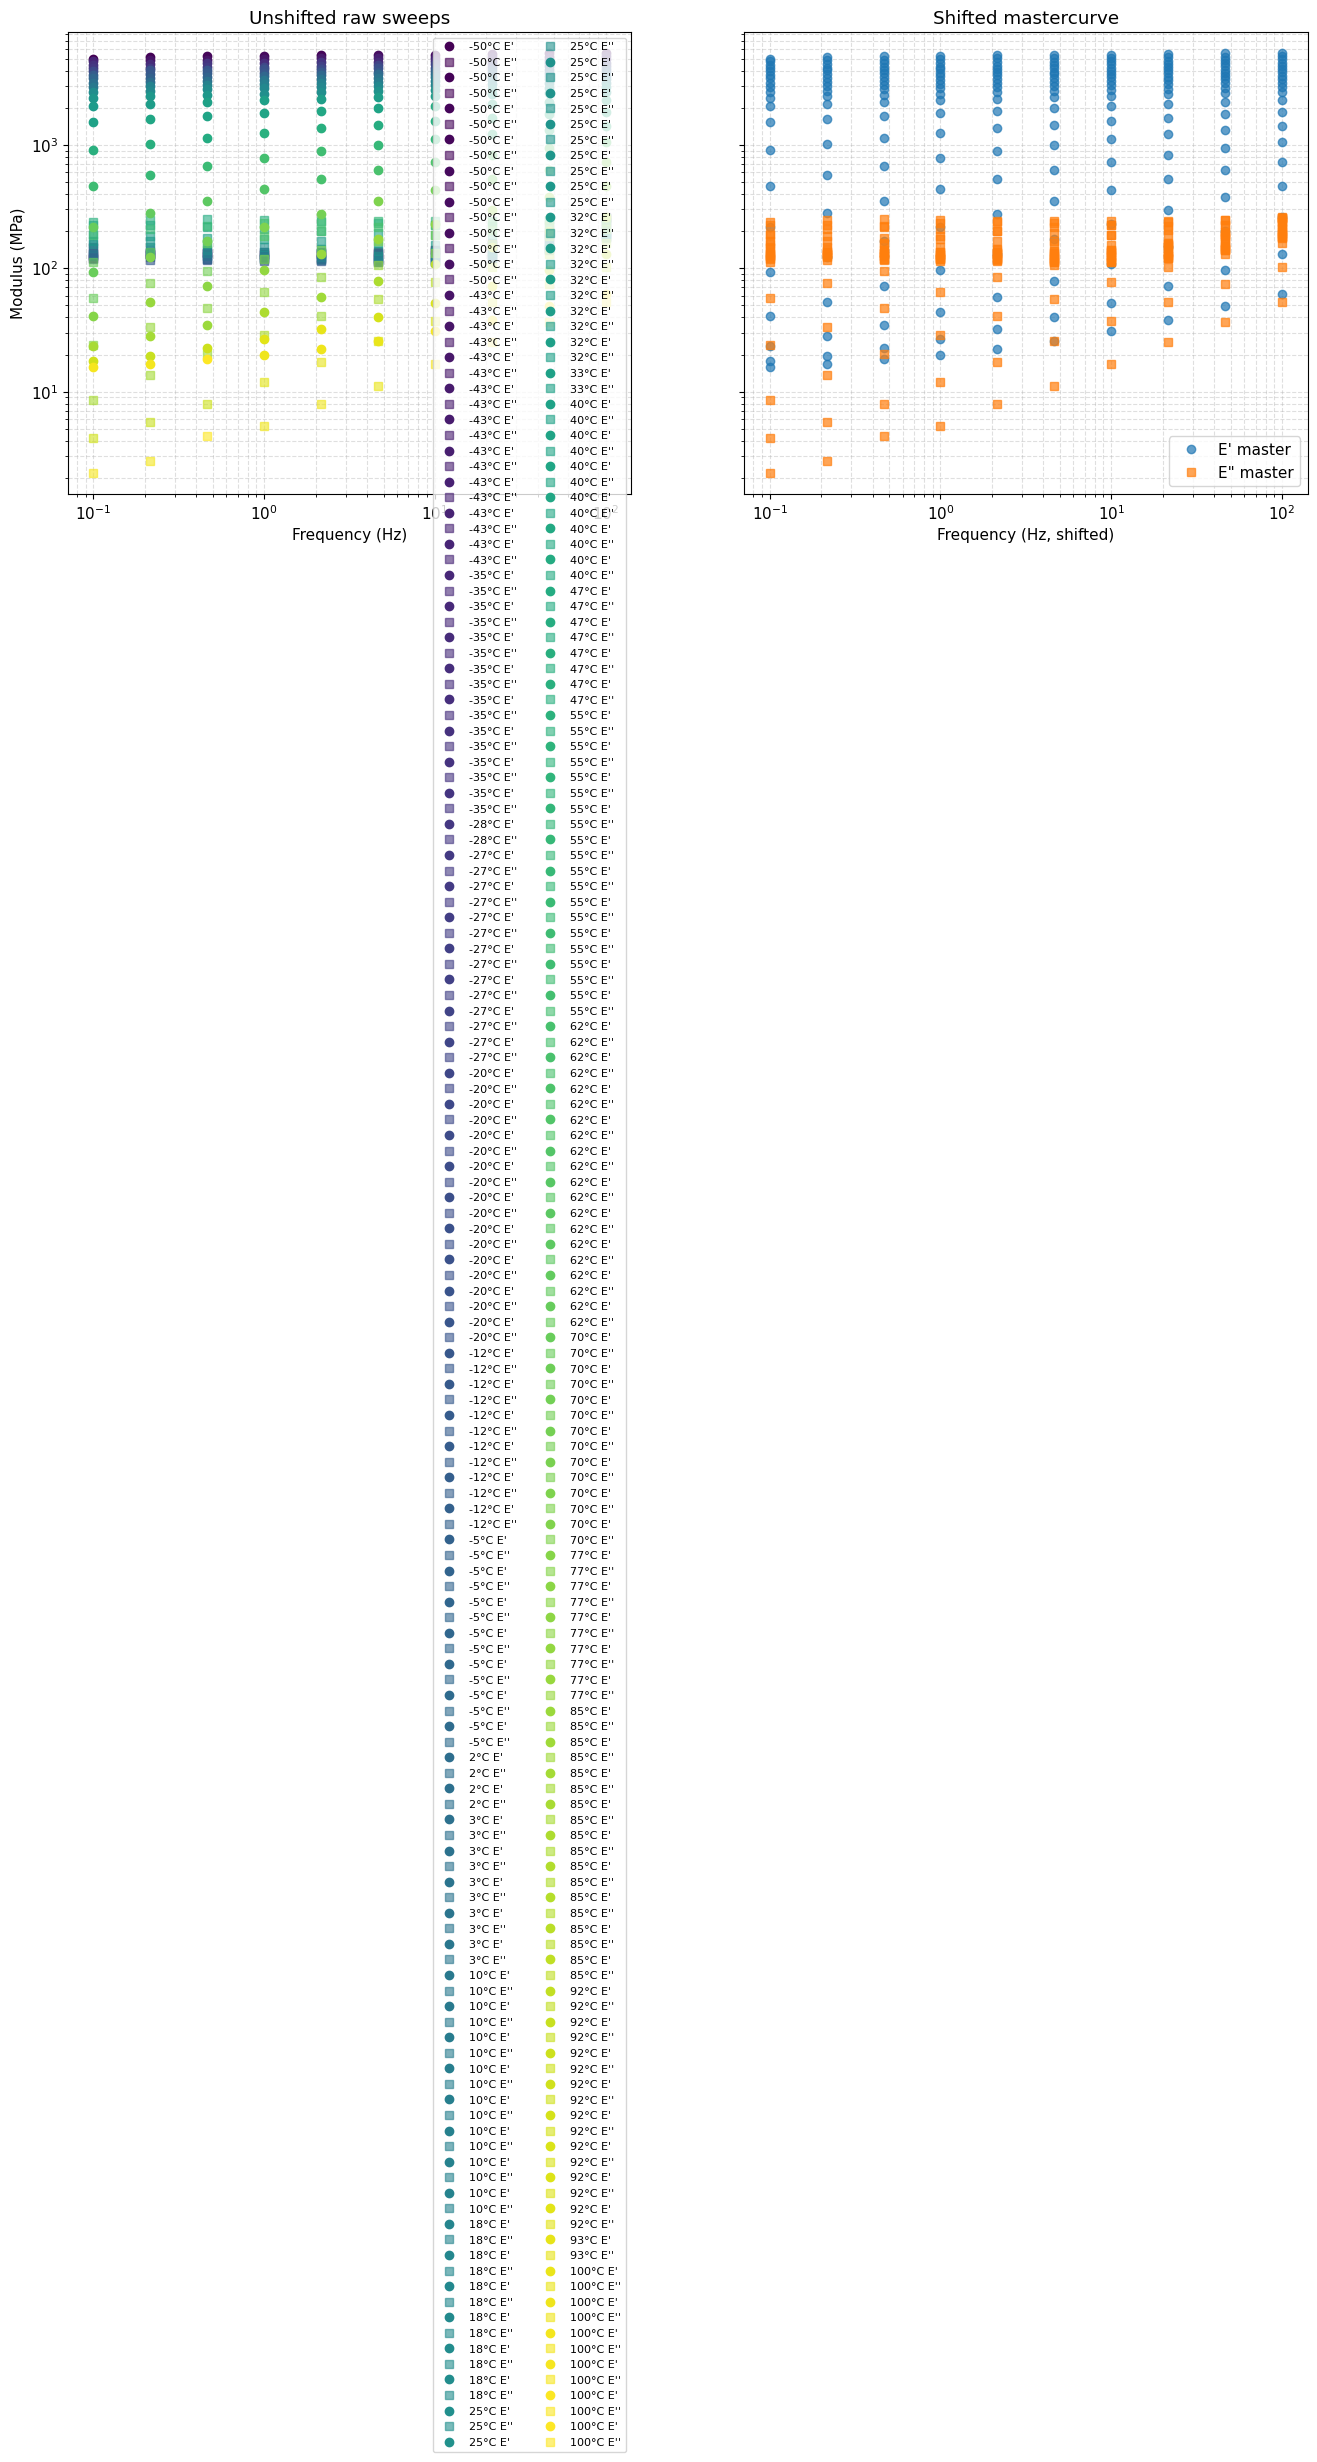

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for color, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x / (2*np.pi), np.real(data.y), 'o', color=color, label=f"{temp_c:.0f}°C E'")
    axes[0].loglog(data.x / (2*np.pi), np.imag(data.y), 's', color=color, alpha=0.6, label=f"{temp_c:.0f}°C E''")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (MPa)')
axes[0].set_title('Unshifted raw sweeps')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x / (2*np.pi), np.real(master.y), 'o', label="E' master", alpha=0.7)
axes[1].loglog(master.x / (2*np.pi), np.imag(master.y), 's', label='E" master', alpha=0.7)
axes[1].set_xlabel('Frequency (Hz, shifted)')
axes[1].set_title('Shifted mastercurve')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

# Generalized Maxwell on mastercurve
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:, 0] + 1j * gm_pred_components[:, 1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print(f"Generalized Maxwell R^2: {gm_r2:.4f}")
print(f"Fractional Maxwell R^2:   {fm_r2 if np.isfinite(fm_r2) else float('nan'):.4f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.646887s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=3.3238e+08 | elapsed=1.647s | final_gradient_norm=1.5666e+13


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.411440s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=3.3238e+08 | elapsed=0.411s | final_gradient_norm=1.5666e+13


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.574216s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=3.3238e+08 | elapsed=1.574s | final_gradient_norm=3.1157e+12


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.344708s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=4 | final_cost=3.3240e+08 | elapsed=1.345s | final_gradient_norm=6.9105e+11


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.840750s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=3.3244e+08 | elapsed=0.841s | final_gradient_norm=3.1064e+05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.834248s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=3.3268e+08 | elapsed=0.834s | final_gradient_norm=2.1778e+12


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.841108s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=19 | final_cost=3.3364e+08 | elapsed=0.841s | final_gradient_norm=5.9897e+11


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.998788s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=156.0306 | elapsed=0.999s | final_gradient_norm=7.6517e+04


Generalized Maxwell R^2: 0.0048
Fractional Maxwell R^2:   -1.8297


## Overlay fits on shifted data

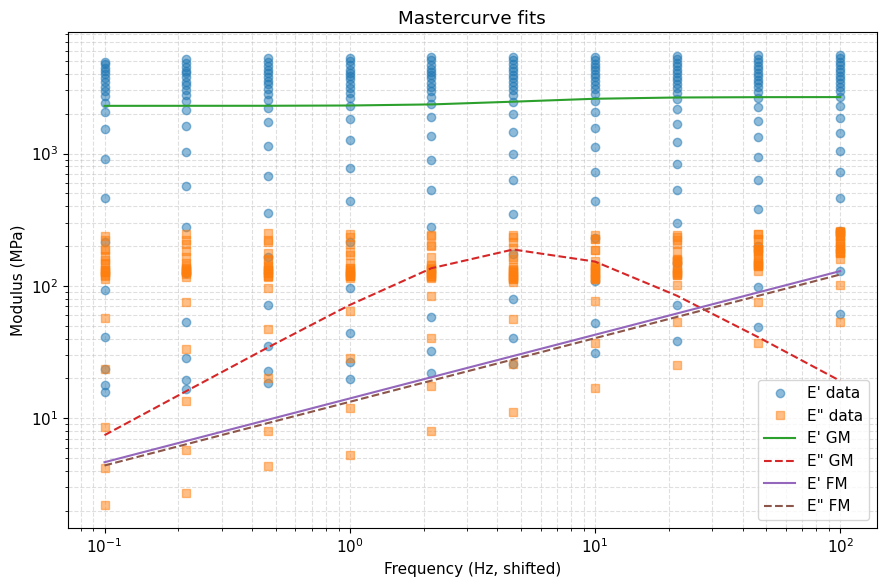

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(master.x / (2*np.pi), np.real(master.y), 'o', label="E' data", alpha=0.5)
ax.loglog(master.x / (2*np.pi), np.imag(master.y), 's', label='E" data', alpha=0.5)
ax.loglog(master.x / (2*np.pi), np.real(gm_pred), '-', label="E' GM")
ax.loglog(master.x / (2*np.pi), np.imag(gm_pred), '--', label='E" GM')

if np.isfinite(fm_r2):
    ax.loglog(master.x / (2*np.pi), np.real(fm_pred), '-', label="E' FM")
    ax.loglog(master.x / (2*np.pi), np.imag(fm_pred), '--', label='E" FM')
else:
    ax.text(0.5, 0.1, 'Fractional fit failed', transform=ax.transAxes)

ax.set_xlabel('Frequency (Hz, shifted)')
ax.set_ylabel('Modulus (MPa)')
ax.set_title('Mastercurve fits')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [7]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [8]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 2 dataset(s) and 2 model(s)


In [9]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


ERROR:rheojax.models.multimode.generalized_maxwell:NLSQ optimization failed with ValueError
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/models/multimode/generalized_maxwell.py", line 271, in _nlsq_fit
    nlsq_result = ls.least_squares(
        objective,
    ...<7 lines>...
        verbose=0,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/least_squares.py", line 1096, in least_squares
    x0, lb, ub, ftol, xtol, gtol, x_scale = self._validate_least_squares_inputs(
                                            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        x0,
        ^^^
    ...<10 lines>...
        prepared_bounds=prepared_bounds,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/least_squares.py", line 540, in _validate_least_squares_inputs
    raise ValueError("`x0` is infeasible.")
ValueError: `x0` is infeasible.


ERROR:rheojax.models.multimode.generalized_maxwell:GMM fitting failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/models/multimode/generalized_maxwell.py", line 271, in _nlsq_fit
    nlsq_result = ls.least_squares(
        objective,
    ...<7 lines>...
        verbose=0,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/least_squares.py", line 1096, in least_squares
    x0, lb, ub, ftol, xtol, gtol, x_scale = self._validate_least_squares_inputs(
                                            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        x0,
        ^^^
    ...<10 lines>...
        prepared_bounds=prepared_bounds,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/least_squares.py", line 540, in _validate_least_squares_inputs
    raise ValueError("`x0` is infeasible.")
ValueError: `x0` is infeasible.

The above exception was the

ERROR:rheojax.models.multimode.generalized_maxwell:model_fit failed: NLSQ optimization failed with error: `x0` is infeasible.
This may indicate:
  1. Data is unsuitable for GMM fitting (e.g., constant values)
  2. Initial parameter guess is outside bounds
  3. Too many modes for the available data


ERROR:rheojax.core.base:Fit failed with RuntimeError
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/models/multimode/generalized_maxwell.py", line 271, in _nlsq_fit
    nlsq_result = ls.least_squares(
        objective,
    ...<7 lines>...
        verbose=0,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/least_squares.py", line 1096, in least_squares
    x0, lb, ub, ftol, xtol, gtol, x_scale = self._validate_least_squares_inputs(
                                            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        x0,
        ^^^
    ...<10 lines>...
        prepared_bounds=prepared_bounds,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/least_squares.py", line 540, in _validate_least_squares_inputs
    raise ValueError("`x0` is infeasible.")
ValueError: `x0` is infeasible.

The above exception was the direct cause of 

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to fit error: NLSQ optimization failed with error: `x0` is infeasible.
This may indicate:
  1. Data is unsuitable for GMM fitting (e.g., constant values)
  2. Initial parameter guess is outside bounds
  3. Too many modes for the available data


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.947178s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=0.2511 | elapsed=0.947s | final_gradient_norm=2.1460


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Dataset 0 ranking: [('fm', -inf)]


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.448210s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=3.3364e+08 | elapsed=0.448s | final_gradient_norm=5.9038e+11


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.527812s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=156.0306 | elapsed=0.528s | final_gradient_norm=7.6517e+04


Dataset 1 ranking: [('fm', -1.83)]


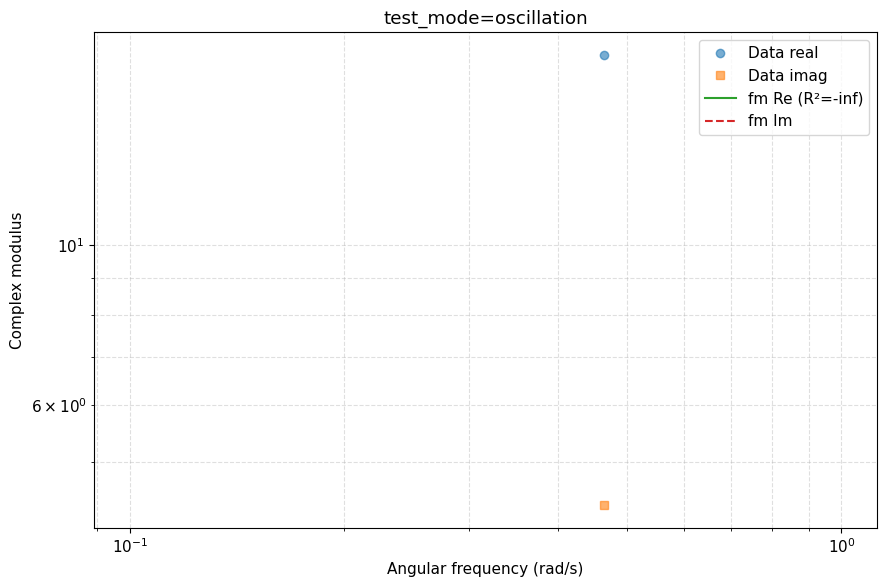

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:40,  2.49it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:  13%|█▎        | 88/700 [00:00<00:02, 229.43it/s, 1 steps of size 2.61e-07. acc. prob=0.89]

warmup:  20%|█▉        | 139/700 [00:00<00:01, 299.73it/s, 1 steps of size 3.43e-06. acc. prob=0.92]

sample:  36%|███▌      | 249/700 [00:00<00:00, 520.09it/s, 1 steps of size 2.18e-05. acc. prob=0.98]

sample:  48%|████▊     | 334/700 [00:00<00:00, 612.52it/s, 31 steps of size 2.18e-05. acc. prob=0.92]

sample:  59%|█████▉    | 412/700 [00:01<00:00, 472.65it/s, 31 steps of size 2.18e-05. acc. prob=0.90]

sample:  68%|██████▊   | 475/700 [00:01<00:00, 481.67it/s, 63 steps of size 2.18e-05. acc. prob=0.90]

sample:  76%|███████▋  | 534/700 [00:01<00:00, 475.71it/s, 255 steps of size 2.18e-05. acc. prob=0.90]

sample:  84%|████████▍ | 589/700 [00:01<00:00, 443.30it/s, 63 steps of size 2.18e-05. acc. prob=0.89] 

sample:  93%|█████████▎| 653/700 [00:01<00:00, 489.43it/s, 63 steps of size 2.18e-05. acc. prob=0.89]

sample: 100%|██████████| 700/700 [00:01<00:00, 436.09it/s, 63 steps of size 2.18e-05. acc. prob=0.89]

Dataset 0: Bayesian inference complete for fm


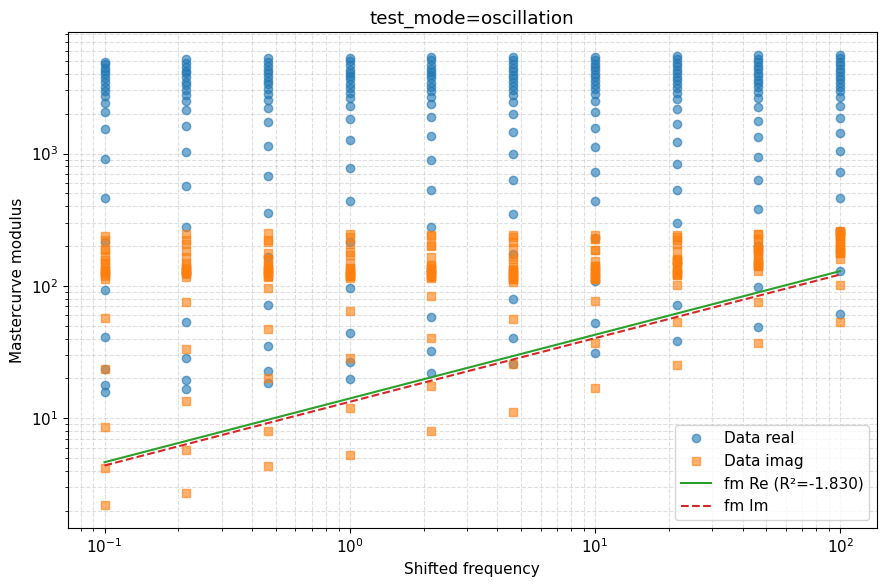

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:40,  2.49it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 15/700 [00:00<00:17, 38.53it/s, 15 steps of size 6.60e-05. acc. prob=0.73]

warmup:   5%|▍         | 32/700 [00:00<00:09, 73.74it/s, 1 steps of size 4.95e-04. acc. prob=0.88] 

warmup:   9%|▉         | 63/700 [00:00<00:04, 139.41it/s, 15 steps of size 4.78e-03. acc. prob=0.93]

warmup:  12%|█▏        | 87/700 [00:00<00:03, 159.41it/s, 1023 steps of size 2.25e-03. acc. prob=0.94]

warmup:  15%|█▌        | 107/700 [00:01<00:06, 97.47it/s, 1023 steps of size 1.48e-03. acc. prob=0.94]

warmup:  17%|█▋        | 122/700 [00:01<00:08, 64.64it/s, 1023 steps of size 2.24e-03. acc. prob=0.95]

warmup:  19%|█▉        | 134/700 [00:01<00:09, 58.86it/s, 1023 steps of size 3.04e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [00:02<00:09, 58.71it/s, 1023 steps of size 3.00e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [00:02<00:09, 60.52it/s, 895 steps of size 3.12e-02. acc. prob=0.95] 

warmup:  23%|██▎       | 159/700 [00:02<00:10, 53.69it/s, 1023 steps of size 2.02e-03. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [00:02<00:11, 47.09it/s, 1023 steps of size 1.89e-03. acc. prob=0.95]

warmup:  25%|██▍       | 172/700 [00:02<00:12, 41.90it/s, 1023 steps of size 1.98e-03. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [00:03<00:14, 35.34it/s, 1023 steps of size 2.40e-03. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [00:03<00:15, 34.53it/s, 1023 steps of size 2.66e-03. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [00:03<00:15, 32.71it/s, 1023 steps of size 2.81e-03. acc. prob=0.96]

warmup:  27%|██▋       | 191/700 [00:03<00:13, 37.67it/s, 1023 steps of size 2.23e-03. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [00:03<00:12, 39.86it/s, 1023 steps of size 2.37e-03. acc. prob=0.96]

sample:  29%|██▉       | 202/700 [00:03<00:11, 42.17it/s, 1023 steps of size 2.39e-03. acc. prob=1.00]

sample:  30%|██▉       | 209/700 [00:03<00:10, 46.36it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  31%|███       | 215/700 [00:03<00:10, 46.74it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  31%|███▏      | 220/700 [00:04<00:11, 43.18it/s, 207 steps of size 2.39e-03. acc. prob=0.98] 

sample:  32%|███▏      | 226/700 [00:04<00:10, 45.90it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  33%|███▎      | 231/700 [00:04<00:10, 45.58it/s, 191 steps of size 2.39e-03. acc. prob=0.98] 

sample:  34%|███▎      | 236/700 [00:04<00:11, 41.19it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [00:04<00:10, 42.46it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  35%|███▌      | 246/700 [00:04<00:10, 42.65it/s, 127 steps of size 2.39e-03. acc. prob=0.98] 

sample:  36%|███▌      | 251/700 [00:04<00:10, 43.14it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  37%|███▋      | 256/700 [00:04<00:10, 43.75it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  37%|███▋      | 261/700 [00:05<00:10, 41.30it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  38%|███▊      | 266/700 [00:05<00:10, 40.32it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  39%|███▉      | 272/700 [00:05<00:09, 43.55it/s, 863 steps of size 2.39e-03. acc. prob=0.98] 

sample:  40%|███▉      | 277/700 [00:05<00:09, 43.50it/s, 1023 steps of size 2.39e-03. acc. prob=0.98]

sample:  40%|████      | 282/700 [00:05<00:10, 38.95it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  41%|████      | 287/700 [00:05<00:10, 41.20it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [00:05<00:09, 41.14it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  42%|████▏     | 297/700 [00:05<00:09, 42.70it/s, 703 steps of size 2.39e-03. acc. prob=0.99] 

sample:  43%|████▎     | 302/700 [00:05<00:09, 40.49it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  44%|████▍     | 308/700 [00:06<00:09, 43.52it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [00:06<00:08, 44.52it/s, 527 steps of size 2.39e-03. acc. prob=0.99] 

sample:  45%|████▌     | 318/700 [00:06<00:08, 45.67it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [00:06<00:08, 43.82it/s, 127 steps of size 2.39e-03. acc. prob=0.99] 

sample:  47%|████▋     | 328/700 [00:06<00:09, 39.70it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [00:06<00:08, 45.36it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  49%|████▊     | 340/700 [00:06<00:08, 44.80it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  49%|████▉     | 345/700 [00:06<00:07, 45.31it/s, 687 steps of size 2.39e-03. acc. prob=0.99] 

sample:  50%|█████     | 350/700 [00:07<00:07, 45.01it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  51%|█████     | 357/700 [00:07<00:06, 50.07it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  52%|█████▏    | 363/700 [00:07<00:07, 42.57it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  53%|█████▎    | 368/700 [00:07<00:07, 42.91it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [00:07<00:07, 40.98it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [00:07<00:07, 40.77it/s, 63 steps of size 2.39e-03. acc. prob=0.99]  

sample:  55%|█████▍    | 383/700 [00:07<00:07, 40.19it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  55%|█████▌    | 388/700 [00:07<00:07, 39.73it/s, 767 steps of size 2.39e-03. acc. prob=0.99] 

sample:  57%|█████▋    | 396/700 [00:08<00:06, 47.64it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [00:08<00:06, 45.13it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [00:08<00:06, 45.78it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  59%|█████▉    | 412/700 [00:08<00:05, 49.07it/s, 511 steps of size 2.39e-03. acc. prob=0.99] 

sample:  60%|█████▉    | 417/700 [00:08<00:06, 46.05it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  60%|██████    | 422/700 [00:08<00:06, 44.10it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  61%|██████    | 427/700 [00:08<00:06, 41.45it/s, 871 steps of size 2.39e-03. acc. prob=0.99] 

sample:  62%|██████▏   | 433/700 [00:08<00:06, 42.44it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [00:09<00:06, 39.25it/s, 991 steps of size 2.39e-03. acc. prob=0.99] 

sample:  64%|██████▎   | 445/700 [00:09<00:05, 44.22it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:09<00:05, 45.67it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [00:09<00:05, 46.07it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [00:09<00:04, 50.14it/s, 911 steps of size 2.39e-03. acc. prob=0.99] 

sample:  67%|██████▋   | 469/700 [00:09<00:04, 51.86it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [00:09<00:04, 47.78it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  69%|██████▊   | 481/700 [00:09<00:04, 50.53it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [00:10<00:04, 52.89it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  70%|███████   | 493/700 [00:10<00:04, 50.32it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [00:10<00:04, 45.08it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  72%|███████▏  | 504/700 [00:10<00:04, 44.37it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [00:10<00:04, 43.35it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [00:10<00:04, 41.02it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [00:10<00:04, 40.94it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [00:10<00:04, 43.53it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [00:11<00:03, 42.54it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [00:11<00:03, 43.89it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [00:11<00:03, 43.30it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [00:11<00:03, 49.06it/s, 655 steps of size 2.39e-03. acc. prob=0.99] 

sample:  79%|███████▉  | 552/700 [00:11<00:03, 45.10it/s, 895 steps of size 2.39e-03. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [00:11<00:03, 39.51it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  81%|████████  | 564/700 [00:11<00:02, 45.41it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [00:11<00:02, 49.03it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  82%|████████▏ | 576/700 [00:12<00:02, 47.09it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [00:12<00:02, 46.53it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [00:12<00:02, 45.56it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [00:12<00:02, 50.37it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [00:12<00:02, 49.21it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [00:12<00:02, 47.68it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [00:12<00:02, 44.40it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [00:12<00:02, 42.69it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [00:13<00:01, 46.99it/s, 431 steps of size 2.39e-03. acc. prob=0.99] 

sample:  89%|████████▉ | 625/700 [00:13<00:01, 43.33it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [00:13<00:01, 46.51it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [00:13<00:01, 49.76it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [00:13<00:01, 52.10it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [00:13<00:01, 50.33it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [00:13<00:00, 48.95it/s, 7 steps of size 2.39e-03. acc. prob=0.99]   

sample:  94%|█████████▍| 660/700 [00:13<00:00, 44.00it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [00:13<00:00, 45.11it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [00:14<00:00, 46.38it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [00:14<00:00, 45.31it/s, 415 steps of size 2.39e-03. acc. prob=0.99] 

sample:  97%|█████████▋| 680/700 [00:14<00:00, 46.53it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [00:14<00:00, 48.79it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [00:14<00:00, 44.54it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [00:14<00:00, 44.27it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:14<00:00, 47.42it/s, 1023 steps of size 2.39e-03. acc. prob=0.99]

Dataset 1: Bayesian inference complete for fm


In [10]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [11]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'tau\n0'}>]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)


--- Diagnostics for dataset 1 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'tau\n0'}>]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)